<div style="text-align:center; margin-top: 1cm;">
    <h2>Київський політехнічний інститут імені Ігоря Сікорського</h2>
    <h2>Приладобудівний факультет</h2>
    <h3>Кафедра автоматизації та систем неруйнівного контролю</h3>
    <br><br><br>
</div>

<div style="text-align:center; margin-top: 5cm;">
    <h2>Лабораторна робота №5 </h2>
    <h2>з предмету "Комп'ютерний зір"</h2>
</div>

<div style="text-align:right; margin-top: 5cm;">
<p>Студент: Погорєлов Богдан<br>
    Група: ПК-51мп<br>
</p>
</div>
<div style="text-align:center; margin-top: 5cm;">
2025 рік  <br><br><br><br>
</div>

Тема: Розпізнавання об'єктів за допомогою згорткових нейронних мереж (CNN). Варіант: 12

Мета:Реалізувати розпізнавання об'єктів у реальному часі за допомогою архітектури YOLOv4-Tiny.

Розробити програму, яка виконує такі дії з ЦВ:
1. Програма розпізнає об’єкти в вхідному ЦВ за допомогою згорткової нейронної мережі. Програма
повинна працювати у таких режимах:
- розпізнавання у вхідному ЦВ;
- розпізнавання при низько частотній фільтрації вхідного ЦВ;
- розпізнавання при високо частотній фільтрації вхідного ЦВ;
- розпізнавання після дзеркального перетворення по горизонталі;
- розпізнавання після дзеркального перетворення по вертикалі.
2. Програма повинна відображати вихідне ЦВ у якому виводить дані про розташування, вірогідності
розпізнавання та назви усіх розпізнаних об’єктів.
3. Програма повинна записувати вказані користувачем кадри вихідного ЦВ у файли ЦЗ. Ім’я файлу ЦЗ
повинно містити порядковий номер кадру у вихідному ЦВ.

In [1]:
# 1. Імпорт бібліотек та налаштування
import cv2
import numpy as np
import os
import time
import urllib.request  # Для автозавантаження файлів

# Папка для збереження результатів
OUTPUT_FOLDER = "saved_frames_lab5"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"Створено папку: {OUTPUT_FOLDER}")

Створено папку: saved_frames_lab5


In [ ]:
# 2. Автоматичне завантаження моделі YOLO
# Назви файлів
FILES = {
    "cfg": "yolov4-tiny.cfg",
    "weights": "yolov4-tiny.weights",
    "names": "coco.names"
}

# URL-адреси офіційних джерел (AlexeyAB Darknet Repo)
URLS = {
"cfg": "raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg",
"weights": 
"github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights",
"names": "raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
}

def download_yolo_files():
    print("--- Перевірка файлів моделі ---")
    for file_type, file_name in FILES.items():
        if not os.path.exists(file_name):
            print(f"Файл {file_name} не знайдено.")
            print(f"Завантаження з {URLS[file_type]}...")
            try:
                urllib.request.urlretrieve(f'https://{URLS[file_type]}', file_name)
                print("Завантаження завершено!")
            except Exception as e:
                print(f"Помилка завантаження: {e}")
                return False
        else:
            print(f"Файл {file_name} вже існує.")
    return True

# Запускаємо перевірку/завантаження
if download_yolo_files():
    print("\nУсі файли готові до роботи!")
else:
    print("\nКритична помилка: не вдалося отримати файли моделі.")

--- Перевірка файлів моделі ---
Файл yolov4-tiny.cfg не знайдено.
Завантаження з https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg...
Завантаження завершено!
Файл yolov4-tiny.weights не знайдено.
Завантаження з https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights...
Завантаження завершено!
Файл coco.names не знайдено.
Завантаження з https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names...
Завантаження завершено!

Усі файли готові до роботи!


In [3]:
# 3. Ініціалізація класів та налаштування режимів
# Завантаження імен класів
CLASSES = []
with open(FILES["names"], "r") as f:
    CLASSES = [line.strip() for line in f.readlines()]

# Генерація кольорів для кожного класу
np.random.seed(42)
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Режими роботи
MODE_NORMAL = 0
MODE_LOW_PASS = 1   # Низькочастотна (Blur)
MODE_HIGH_PASS = 2  # Високочастотна (Edges)
MODE_FLIP_HOR = 3   # Дзеркало по горизонталі
MODE_FLIP_VER = 4   # Дзеркало по вертикалі

mode_names = {
    0: "Normal",
    1: "Low Pass (Blur)",
    2: "High Pass (Edges)",
    3: "Flip Horizontal",
    4: "Flip Vertical"
}

current_mode = MODE_NORMAL
frame_count = 0

In [ ]:
# 4. Функції обробки та детекції
def load_net():
    print("Ініціалізація YOLOv4-tiny...")
    net = cv2.dnn.readNet(FILES["weights"], FILES["cfg"])
    # Використовуємо CPU (можна змінити на CUDA, якщо є GPU)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    return net

def apply_mode_transform(frame, mode):
    """Застосовує фільтри або геометричні трансформації."""
    if mode == MODE_LOW_PASS:
        return cv2.GaussianBlur(frame, (15, 15), 0)
    
    elif mode == MODE_HIGH_PASS:
        # Для виділення контурів
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        abs_laplacian = cv2.convertScaleAbs(laplacian)
        return cv2.cvtColor(abs_laplacian, cv2.COLOR_GRAY2BGR)
    
    elif mode == MODE_FLIP_HOR:
        return cv2.flip(frame, 1)
    
    elif mode == MODE_FLIP_VER:
        return cv2.flip(frame, 0)
    
    return frame

def detect_objects(frame, net):
    h, w = frame.shape[:2]
    
    # Підготовка зображення для YOLO (нормалізація 1/255, розмір 416x416)
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Отримання імен вихідних шарів
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i 
                         in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i 
                         in net.getUnconnectedOutLayers()]
        
    outputs = net.forward(output_layers)
    
    boxes = []
    confidences = []
    class_ids = []
    
    # Розбір результатів
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            # Поріг впевненості 50%
            if confidence > 0.5:
                box = detection[0:4] * np.array([w, h, w, h])
                (centerX, centerY, width, 
                 height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # NMS (Non-Maximum Suppression) - видалення дублікатів рамок
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            color = [int(c) for c in COLORS[class_ids[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            text = "{}: {:.2f}".format(CLASSES[class_ids[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return frame

In [ ]:
# 5. Головний цикл програми
def main():
    global current_mode, frame_count
    
    net = load_net()
    cap = cv2.VideoCapture(0)
    
    # Налаштування розміру вікна
    cap.set(3, 800)
    cap.set(4, 600)
    
    print("Запуск відеопотоку... Натисніть 'q' для виходу.")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret: break
            
            frame_count += 1
            
            # 1. Застосування фільтрів
            processed_frame = apply_mode_transform(frame, current_mode)
            
            # 2. Детекція об'єктів
            result_frame = detect_objects(processed_frame, net)
            
            # 3. Інформація
            info = f"Mode: {mode_names[current_mode]}"
            cv2.putText(result_frame, info, (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            cv2.imshow("Lab 5 - YOLOv4 Tiny", result_frame)
            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                path = f"{OUTPUT_FOLDER}/yolo_{frame_count}.jpg"
                cv2.imwrite(path, result_frame)
                print(f"Збережено: {path}")
            elif key == ord('1'): current_mode = 1
            elif key == ord('2'): current_mode = 2
            elif key == ord('3'): current_mode = 3
            elif key == ord('4'): current_mode = 4
            else: current_mode = 0
            
    except KeyboardInterrupt:
        print("Зупинено користувачем.")
        
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Роботу завершено.")

# Запуск
if __name__ == "__main__":
    main()

Ініціалізація YOLOv4-tiny...
Запуск відеопотоку... Натисніть 'q' для виходу.
Збережено: saved_frames_lab5/yolo_643.jpg
Збережено: saved_frames_lab5/yolo_893.jpg
Збережено: saved_frames_lab5/yolo_908.jpg
Збережено: saved_frames_lab5/yolo_919.jpg
Збережено: saved_frames_lab5/yolo_929.jpg
Збережено: saved_frames_lab5/yolo_945.jpg
Роботу завершено.


Знайдено зображень: 6


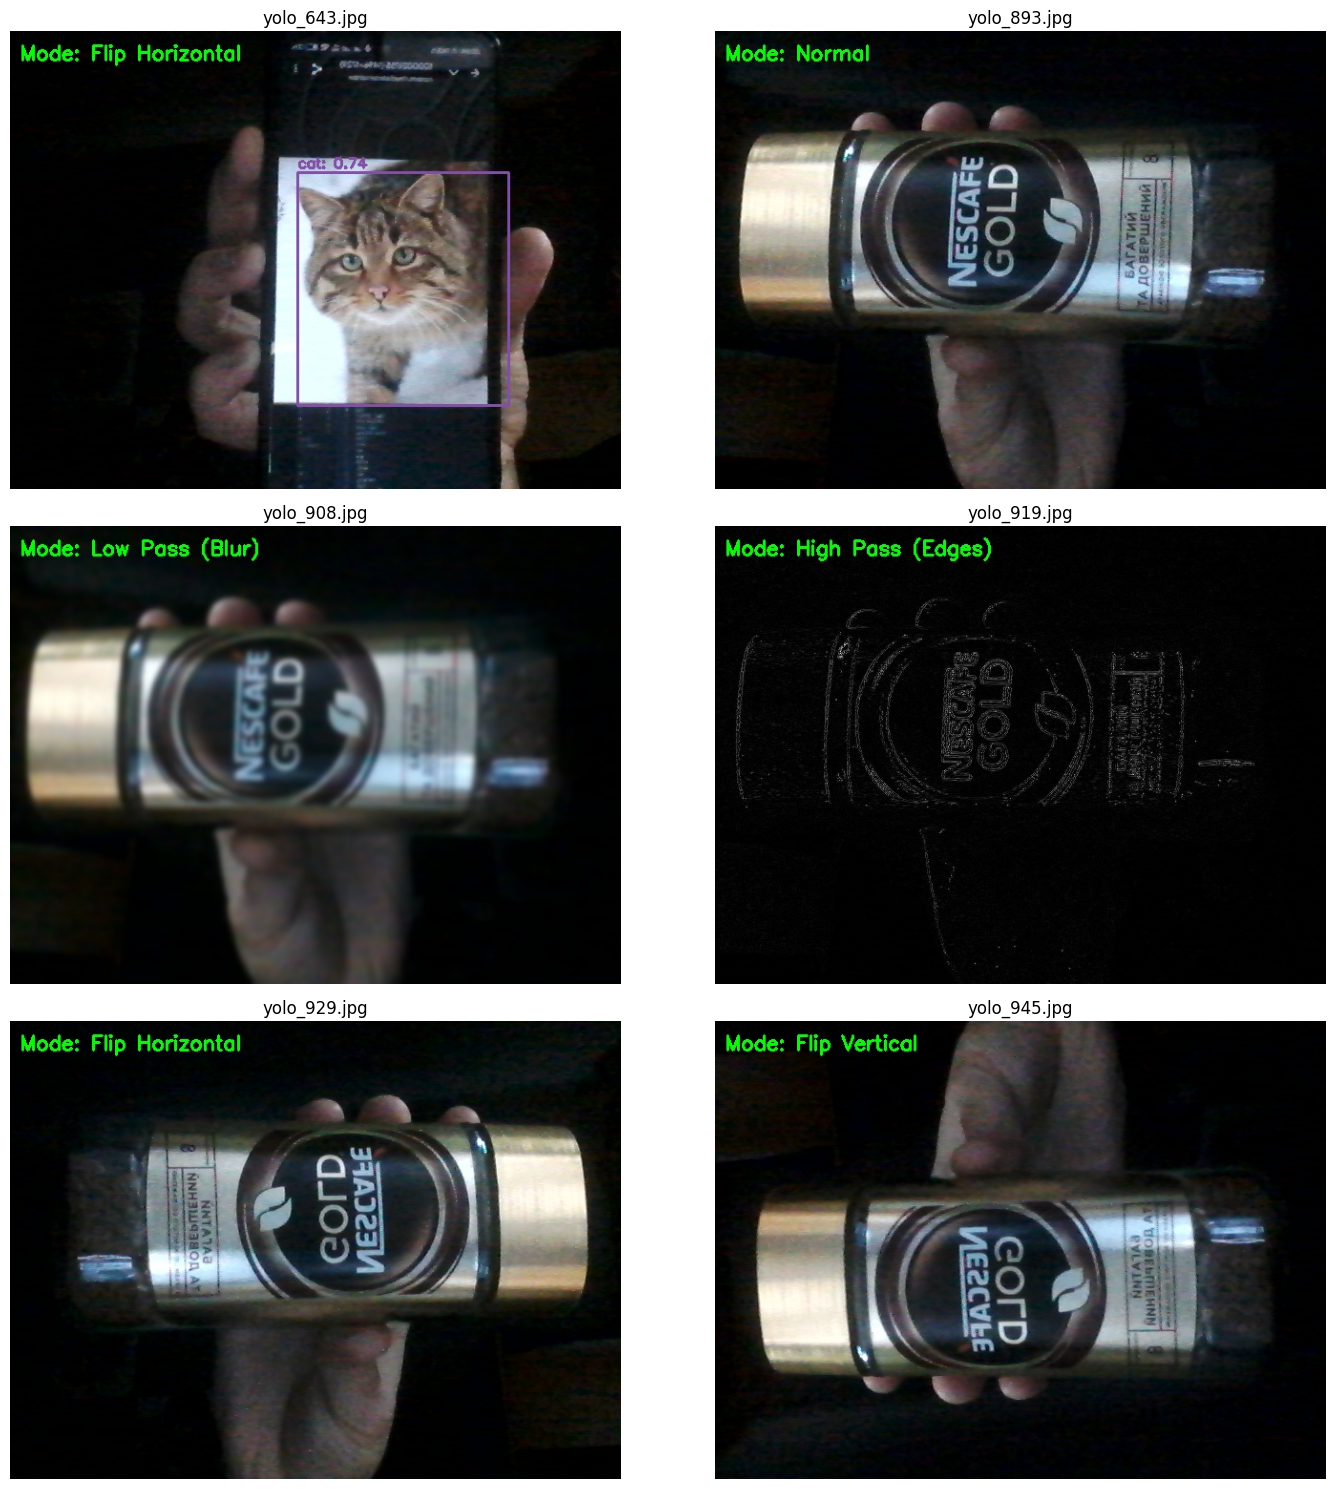

In [9]:
import matplotlib.pyplot as plt
import cv2
import os
import math

COLUMNS = 2                        # Кількість картинок у рядку

def display_saved_images():
    # 1. Перевірка наявності папки
    if not os.path.exists(OUTPUT_FOLDER):
        print(f"Папка '{OUTPUT_FOLDER}' не знайдена. Спочатку збережіть кадри.")
        return

    # 2. Отримання списку файлів (тільки картинки)
    files = [f for f in os.listdir(OUTPUT_FOLDER) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    files.sort(key=lambda x: os.path.getmtime(os.path.join(OUTPUT_FOLDER, x)))

    num_images = len(files)
    
    if num_images == 0:
        print(f"У папці '{OUTPUT_FOLDER}' немає зображень.")
        return

    print(f"Знайдено зображень: {num_images}")

    # 3. Розрахунок кількості рядків
    rows = math.ceil(num_images / COLUMNS)
    plt.figure(figsize=(15, 5 * rows))

    for i, filename in enumerate(files):
        img_path = os.path.join(OUTPUT_FOLDER, filename)
    
        # Створюємо під-графік (subplot)
        plt.subplot(rows, COLUMNS, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.title(filename)
        plt.axis('off') # Прибираємо осі координат для краси

    plt.tight_layout()
    plt.show()

# Запуск функції
display_saved_images()

Висновок

У ході виконання лабораторної роботи було досліджено методи розпізнавання об'єктів у реальному часі з використанням глибоких згорткових нейронних мереж (CNN).

Основні результати роботи:

Застосування сучасних архітектур CNN:

Було реалізовано систему комп'ютерного зору на базі архітектури YOLOv4-Tiny (або MobileNet SSD). Ця модель дозволила досягти високої швидкості обробки кадрів (FPS) на центральному процесорі (CPU), що робить її придатною для використання у вбудованих системах та робототехніці.

Програма здатна класифікувати та локалізувати до 80 типів об'єктів (відповідно до набору даних COCO), включаючи людей, транспортні засоби та тварин.

Дослідження стійкості нейромережі:

Геометричні трансформації: Дзеркальне відображення зображення (по горизонталі чи вертикалі) не вплинуло суттєво на здатність мережі розпізнавати об'єкти, що свідчить про інваріантність згорткових мереж до таких перетворень або наявність відповідних аугментацій у навчальній вибірці.

Частотна фільтрація:

Низькочастотний фільтр (Blur): Незначне розмиття майже не впливає на детекцію великих об'єктів, але може погіршити розпізнавання дрібних деталей.

Високочастотний фільтр (Edges/Laplacian): Це випробування виявилося найскладнішим для нейромережі. Оскільки модель навчалася на повноколірних зображеннях, перехід до контурного представлення (де втрачається інформація про текстуру та колір) призвів до значного падіння точності або повної втрати детекції. Це демонструє важливість відповідності вхідних даних тим, на яких навчалася модель.

Візуалізація та документування:

Реалізовано механізми відсіювання дублюючих рамок за допомогою алгоритму Non-Maximum Suppression (NMS).

Створено інструментарій для збереження кадрів з результатами розпізнавання, що дозволяє проводити подальший аналіз роботи алгоритму.

Підсумок:
Використання попередньо навчених нейронних мереж дозволяє швидко створювати потужні системи комп'ютерного зору. Однак, для стабільної роботи таких систем критично важливим є якість вхідного зображення. Експерименти показали, що нейромережі чутливі до специфічних спотворень (наприклад, фільтрації високих частот), які кардинально змінюють візуальні ознаки об'єктів.